# Implementation: Hidden Markov Model

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mv_normal
from scipy.misc import logsumexp
import matplotlib.mlab as mlab
from scipy.stats import chi2
from matplotlib.patches import Ellipse

We start off by loading the training data:

In [2]:
train_data = np.loadtxt('data/EMGaussian.train')
test_data = np.loadtxt('data/EMGaussian.test')

We will define a helper function that will help us compute the Gaussian pdf. This method will be used to plot the contours as well.

In [3]:
def mv_gauss(X, Y, mu, cov):
    sigma_x = np.sqrt(cov[0,0])
    sigma_y = np.sqrt(cov[1,1])
    sigma_xy = np.sqrt(cov[0,1])
    
    mu_x = mu[0]
    mu_y = mu[1]
    
    return mlab.bivariate_normal(X, Y, sigma_x, sigma_y, mu_x, mu_y, sigma_xy)

def mv_gauss_state(data, state_means, state_covs):
    
    prob_by_state = []
    
    for mu, sigma in zip(state_means, state_covs):
        prob_by_state.append(mv_normal.pdf(x=data, cov=sigma, mean=mu))
    return np.column_stack(prob_by_state)

# Implementation of the $\alpha$ and $\beta$ recursions

We start by implementing the alpha-beta recursion.

We will use the scaling coefficient trick to avoid underflow. Explained in the [Rabiner paper](http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf) we will compute the following scaling coefficient at every time step in the forward algorithm:

$c_t = \frac{1}{\sum_{i = 1}^K  \alpha_t(i)}$

and we have the following scaled $\alpha$'s:


$\alpha_t\prime(i) = \frac{\alpha_t(i)}{\sum_{i = 1}^K  \alpha_t(i)} = \frac{\alpha_t(i)}{c_t}$

In [456]:
def forward(A, pi, data, cov_matrices, state_means, n_states=4):
    T = data.shape[0]
    probs = mv_gauss_state(data, state_means, cov_matrices)    
    alpha = np.zeros((T, n_states))
    c = np.ones(T)

    # Initialization
    alpha[0, :] = pi * probs[0]
    c[0] = np.sum(alpha[0])

    # Scaling (avoid underflow)
    c[0] = 1/c[0]
    alpha[0] *= c[0]

    # Recursive computation of alpha
    for t in range(1, T):
        alpha[t, :] = probs[t, :] * A.T.dot(alpha[t-1,:])
        c[t] = np.sum(alpha[t])
        
        # scaling
        c[t] = 1/c[t]
        alpha[t] *= c[t]
            
    return alpha, c, probs

def backward(A, data, cov_matrices, state_means, scale_coeff, n_states=4):
    T = data.shape[0]
    probs = mv_gauss_state(data, state_means, cov_matrices)    
    beta = np.zeros((T, n_states))

    # Initialization
    beta[T-1, :] = 1

    # Recursive computation of alpha
    for t in reversed(xrange(T-1)):
        beta[t, :] = A.dot(probs[t+1] * beta[t+1])
        # Scaling
        beta[t] *= scale_coeff[t+1]
    
    return beta

# Fake parameter inference

In [457]:
cov_1 = np.array([[ 2.90442381,  0.20655763],
                  [ 0.20655763,  2.75617077]])
cov_2 = np.array([[  0.21035667,   0.29045085],
                  [  0.29045085,  12.23996609]])
cov_3 = np.array([[ 0.92127927,  0.0573808 ],
                  [ 0.0573808 ,  1.86586017]])
cov_4 = np.array([[ 6.24140909,  6.05017464],
                  [ 6.05017464,  6.18245528]])

mu_1 = np.array([-2.03436695,  4.17258596])
mu_2 = np.array([ 3.97793025,  3.77333059])
mu_3 = np.array([ 3.80070949, -3.79729742])
mu_4 = np.array([-3.06196072, -3.53454048])


covs = [cov_1, cov_2, cov_3, cov_4]
means = [mu_1, mu_2, mu_3, mu_4]

A = np.ones((4,4)) * 1/4
np.fill_diagonal(A, 1/6)
pi = np.ones(4) * 1/4

In [458]:
alphas, c, p = forward(A, pi, train_data, covs, means)
betas = backward(A, train_data, covs, means, c)

In [459]:
posterior = alphas * betas

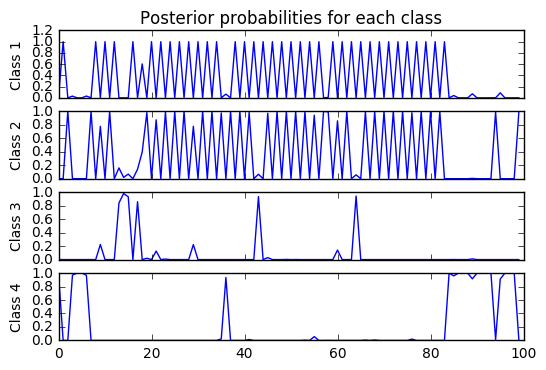

In [460]:
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(np.arange(0,100), posterior[:100, 0])
axarr[0].set_title('Posterior probabilities for each class')
axarr[0].set_ylabel('Class 1')

axarr[1].plot(np.arange(0,100), posterior[:100, 1])
axarr[1].set_ylabel('Class 2')

axarr[2].plot(np.arange(0,100), posterior[:100, 2])
axarr[2].set_ylabel('Class 3')

axarr[3].plot(np.arange(0,100), posterior[:100, 3])
axarr[3].set_ylabel('Class 4')

plt.show()

# EM algorithm to learn parameters of the model

In [461]:
class EM_HMM:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data, means, covs, pi, A, MAX_ITER = 100):
        # We start off by initializing our gaussian mixture parameters with the parameters given to us
        self.means = np.array(means)
        self.covs = [np.eye(self.n_dims)] * self.k
        self.A = A
        self.xisum = np.zeros((self.k, self.k))
        self.probs = None
        self.loglike = []
        
        T = train_data.shape[0]
        
        # compute the sample covariance of each cluster
        self.covs = np.array(covs)

        # posterior probabilities or the weights N x K matrix
        self.taus = np.zeros(shape=(train_data.shape[0], self.k))  
        self.pi = pi      
        n_iter = 0
        
        while(n_iter < MAX_ITER):            
            # E step            
            alpha, self.c, self.probs = forward(A, self.pi, train_data, self.covs, self.means)
            beta = backward(A, train_data, self.covs, self.means, self.c)            
            self.taus = alpha*beta
            self.loglike.append(self.log_likelihood()/T)
            
            # Computing the coocurence probabilities matrix          
            self.xisum = np.zeros((self.k, self.k))
            for t in xrange(1, T):
                self.xisum += np.sum(np.outer(alpha[t-1], self.probs[t] * beta[t]*c[t]), axis=0) * self.A
            
            # M step            
            # Compute the new means and covariance matrices
            for i in xrange(self.k):
                tau_sum = np.sum(self.taus[:, i])
                # First the mean for cluster i
                self.means[i] = (np.sum(self.taus[:, i].reshape(self.taus.shape[0], 1) * train_data, axis=0) / tau_sum)
                
                distance = train_data - self.means[i]
                self.covs[i] = (distance.T.dot(self.taus[:, i].reshape(self.taus.shape[0], 1) * distance) / tau_sum)
                self.pi = self.taus[0]
                
            self.A = (self.xisum/np.sum(self.xisum, axis=0))

            n_iter += 1
    
    def assign_cluster(self, data):
        taus = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
                taus[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], self.covs[i], True)
                
        clusters = np.zeros(data.shape[0], dtype=int)
        for i, x in enumerate(data):
            clusters[i] = np.argmax(taus[i, :])
        return clusters
    
    def log_likelihood(self):
        
        logpi = np.log(self.pi)
        logA = np.log(self.A)
        logP = np.log(self.probs)
        
        #loglike = np.sum(self.taus[0] * logpi) + np.sum(np.sum(self.xisum * logA)) + np.sum(np.sum(self.taus * logP,axis=1))
    
        return -np.sum(np.log(self.c))
                

In [462]:
em = EM_HMM(k=4)
em.train(train_data, means, covs, pi, A, MAX_ITER=10)

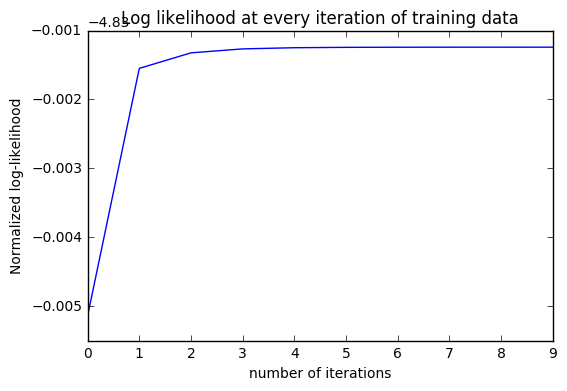

In [463]:
plt.plot(np.arange(0,len(em.loglike)), em.loglike)
plt.ylabel('Normalized log-likelihood')
plt.xlabel('number of iterations')
plt.title('Log likelihood at every iteration of training data')
plt.show()

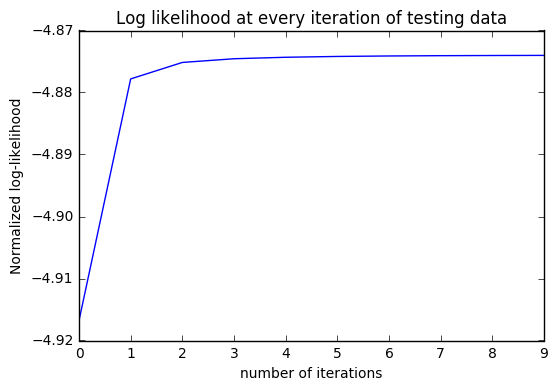

In [464]:
em = EM_HMM(k=4)
em.train(test_data, means, covs, pi, A, MAX_ITER=10)
plt.plot(np.arange(0,len(em.loglike)), em.loglike)
plt.ylabel('Normalized log-likelihood')
plt.xlabel('number of iterations')
plt.title('Log likelihood at every iteration of testing data')
plt.show()

We see that both have about the same rate of convergence. However the likelihood on the testing data is smaller

# Viterbi decoding algorithm

[Source (Wikipedia)](https://en.wikipedia.org/wiki/Viterbi_algorithm)

In [465]:
np.seterr(divide='ignore')
def viterbi(data, pi, A, probs, n_states=4):
    T = data.shape[0]
    T1 = np.ones((n_states, T))
    T2 = np.zeros((n_states, T), dtype=int)
    T1[:,0] = np.log(pi) + np.log(probs[0])
    
    for i in xrange(T):
        for j in xrange(n_states):
            T1[j,i] = np.max(T1[:,i-1] + np.log(A.T[:, j])) + np.log(probs[i,j])
            T2[j,i] = np.argmax(T1[:,i-1] + np.log(A.T[:, j]))
    
    z = np.zeros(T, dtype=int)
    
    z[T-1] = np.argmax(T1[:, T-1])
    
    for i in list(xrange(T-1, 0, -1)):
        z[i-1] = T2[z[i], i]

    return z

In [466]:
probs = mv_gauss_state(train_data, em.means, em.covs)
z_star = viterbi(train_data, em.pi, em.A, probs)

# Data representation

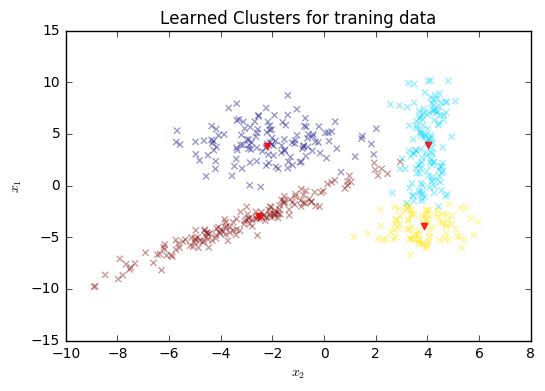

In [467]:
plt.scatter(train_data[:,0], train_data[:,1], marker='x', c=z_star, alpha=0.4)
plt.scatter(em.means[:,0], em.means[:,1], marker='v', color='red', alpha=0.8)
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
plt.title('Learned Clusters for traning data')
plt.show()

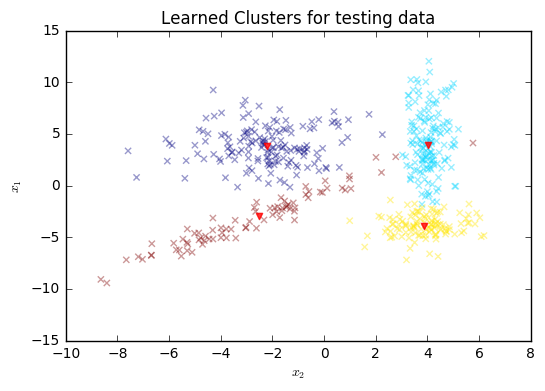

In [468]:
probs = mv_gauss_state(test_data, em.means, em.covs)
z_star = viterbi(test_data, em.pi, em.A, probs)

plt.scatter(test_data[:,0], test_data[:,1], marker='x', c=z_star, alpha=0.4)
plt.scatter(em.means[:,0], em.means[:,1], marker='v', color='red', alpha=0.8)
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
plt.title('Learned Clusters for testing data')
plt.show()

# Marginals on test data

In [469]:
alphas, c, p = forward(em.A, em.pi, test_data, em.covs, em.means)
betas = backward(em.A, test_data, em.covs, em.means, c)

In [470]:
posterior = alphas * betas

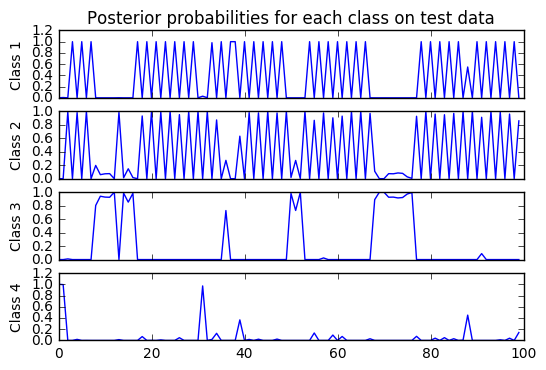

In [471]:
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(np.arange(0,100), posterior[:100, 0])
axarr[0].set_title('Posterior probabilities for each class on test data')
axarr[0].set_ylabel('Class 1')

axarr[1].plot(np.arange(0,100), posterior[:100, 1])
axarr[1].set_ylabel('Class 2')

axarr[2].plot(np.arange(0,100), posterior[:100, 2])
axarr[2].set_ylabel('Class 3')

axarr[3].plot(np.arange(0,100), posterior[:100, 3])
axarr[3].set_ylabel('Class 4')

plt.show()

In [472]:
most_likely_states = np.argmax(posterior, axis=1) + 1

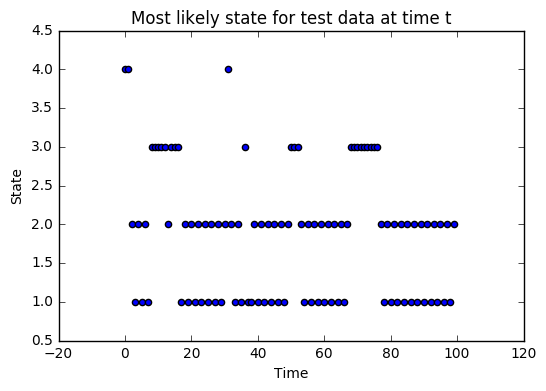

In [473]:
plt.scatter(np.arange(0,100), most_likely_states[:100])
plt.title('Most likely state for test data at time t')
plt.ylabel('State')
plt.xlabel('Time')
plt.show()

# Viterbi on test data

In [474]:
probs = mv_gauss_state(test_data, em.means, em.covs)
z_star = viterbi(test_data, em.pi, em.A, probs) +1

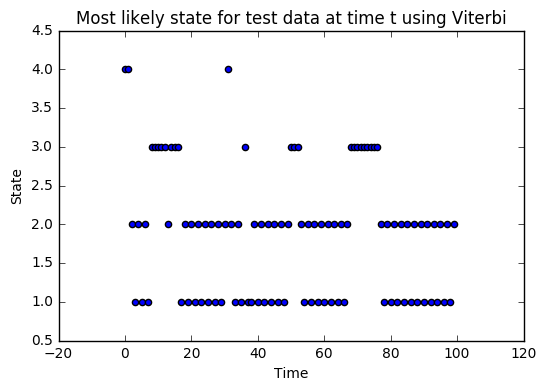

In [475]:
plt.scatter(np.arange(0,100), z_star[:100])
plt.title('Most likely state for test data at time t using Viterbi')
plt.ylabel('State')
plt.xlabel('Time')
plt.show()
plt.show()

We notice that it's the exact same plot

If the number of states K was unkown, one could decide on a value for K by plotting various projection of the data and examining how the data forms clusters according to different projections. Once a K is chosen plot the likelihood of the model and try again with different values of K. Choose the K that has the best likelihood